In [1]:
# necessary for data import
import xml.etree.ElementTree as ET

import numpy as np

import pickle
import skimage.io as skio


In [2]:
from tqdm import tqdm
import matplotlib.pyplot as plt

import skimage as sk


In [3]:
from skimage.transform import resize

import matplotlib.patches as patches

In [2]:
import torch



from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils


import torch.nn as nn
import torch.nn.functional as F


from sklearn.model_selection import train_test_split

import glob



In [4]:
# device = 'cuda' if torch.cuda.is_available() else 'cpu'
# print('Using {} device'.format(device))


Using cuda device


In [5]:
def display_grid_of_images(array_of_images, array_of_names, w = 6, h = 5, normalize_rgb = False, hide_axes = True):
    num_rows = len(array_of_images)
    num_cols = len(array_of_images[0])
    
    assert len(array_of_names) == num_rows, "same num of rows for names and images"
    
    assert all([len(row) == num_cols for row in array_of_images]), "all rows need to be same length"
    assert all([len(row) == num_cols for row in array_of_names]), "all rows need to be same length for strings too"
    
    fig = plt.figure(figsize=(w * num_cols, h * num_rows))
    subplots = fig.subplots(num_rows, num_cols, squeeze = False)
    
    for row in range(num_rows):
        for col in range(num_cols):
            
            ax = subplots[row, col]
            ax.set_title(array_of_names[row][col])
            pixels = array_of_images[row][col]
            if hide_axes:
                ax.set_axis_off()
            
            if len(pixels.shape) == 2:
                # grayscale (scalars)
                ax.imshow(pixels,cmap='Greys_r')
            if len(pixels.shape) == 3:
                # rgb
                if normalize_rgb:
                    # gotta normalize the rgb ones too!
                    pixels = pixels - np.min(pixels)
                    pixels = pixels / np.max(pixels)
                ax.imshow(pixels)
def display_dictionary_of_images(dic, prefix = '', horiz = False, w = 6, h = 5, normalize_rgb = False, hide_axes = True):
    %matplotlib inline
    
    if horiz:
    
        fig = plt.figure(figsize=(w * len(dic), h))
        try:
            subplots = list(fig.subplots(1, len(dic)))
        except:
            subplots = [fig.subplots(1, len(dic))]
    else:
        fig = plt.figure(figsize=(w, h * len(dic)))
        try:
            subplots = list(fig.subplots(len(dic), 1))
        except:
            subplots = [fig.subplots(len(dic), 1)]
    
    keylist = list(dic.keys())
    
    for i in range(len(dic)):
        key = keylist[i]      
        pixels = dic[key]

        #Display the image
        ax = subplots[i]
        ax.set_title(prefix + ' ' + key)
        if hide_axes:
                ax.set_axis_off()
        if len(pixels.shape) == 2:
            # grayscale (scalars)
            ax.imshow(pixels,cmap='Greys_r')
        if len(pixels.shape) == 3:
            # rgb
            # gotta normalize the rgb ones too!
            if normalize_rgb:
                pixels = pixels - np.min(pixels)
                pixels = pixels / np.max(pixels)
            ax.imshow(pixels)

In [4]:
DATA_PATH = 'data/ibug_300W_large_face_landmark_dataset/'

train_xml_tree = ET.parse(DATA_PATH + 'labels_ibug_300W_train.xml')

train_xml_root = train_xml_tree.getroot()

train_xml_images = train_xml_root[2]

len(train_xml_images)

6666

box: top, left, width, height

In [64]:
all_train_data = []

In [65]:
def grow_box(box, x_factor, y_factor):
    assert x_factor >= 1 and y_factor >= 1
    overall_increase_x = int(box[2] * (x_factor - 1))
    overall_increase_y = int(box[3] * (y_factor - 1))
    return [box[0] - overall_increase_y//2, box[1] - overall_increase_x//2, box[2] + overall_increase_x, box[3] + overall_increase_y]

IMG_SIZE = 250

In [84]:
curr_image = train_xml_images[116]

0
0


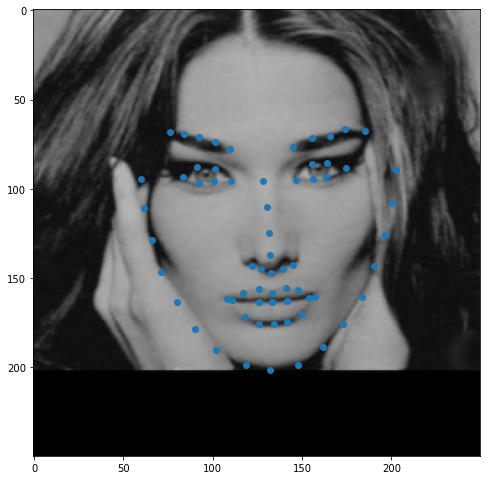

In [95]:
filename = curr_image.attrib['file']

img = skio.imread(DATA_PATH + filename)

if len(img.shape) < 3:
    img = np.stack([img]*3, axis=2)


box_object = curr_image[0]

box_info = [int(value) for value in box_object.attrib.values()]


big_box = grow_box(box_info, 1.8, 1.8)
w, h = big_box[2], big_box[3]
start_x, start_y = big_box[1], big_box[0]

# read points
points = np.zeros((68, 2)).astype(int)
for i in range(68):
    point_object = box_object[i]
    x, y = point_object.attrib['x'], point_object.attrib['y']
    x, y = int(x), int(y)
    points[i] = x, y
    
# adjust points to be relative of box
points_adjusted = points - np.array([big_box[1], big_box[0]])
points_relative = (points_adjusted.astype(float))/np.array([w, h])


print(top_pad)
print(left_pad)
# pad top and left
top_pad = max(-start_y, 0)
left_pad = max(-start_x, 0)
img_padded = np.pad(img, ((top_pad, 0), (left_pad, 0), (0,0)))
start_x_adjusted = max(start_x, 0)
start_y_adjusted = max(start_y, 0)

# pad the bottom and right
img_padded = np.pad(img_padded, ((0, max(0, h + start_y_adjusted - img_padded.shape[0])),
                                 (0 , max(0, w + start_x_adjusted - img_padded.shape[1])), (0,0)))

# crop with the box
img_cropped = img_padded[start_y_adjusted:start_y_adjusted + h, start_x_adjusted:start_x_adjusted+w, :]
img_cropped = resize(img_cropped, (IMG_SIZE,IMG_SIZE), anti_aliasing=True)



# show

fig = plt.figure(figsize=(8, 10))

ax = fig.subplots()


# ax.imshow(img)
ax.imshow(img_cropped)

ax.scatter(*zip(*(points_relative * IMG_SIZE)))
# ax.scatter(*zip(*(points)))

In [91]:
np.pad(img, ((0, 0), (0, 0), (0,0)))

array([[[148, 148, 148],
        [148, 148, 148],
        [148, 148, 148],
        ...,
        [129, 129, 129],
        [112, 112, 112],
        [ 99,  99,  99]],

       [[151, 151, 151],
        [151, 151, 151],
        [151, 151, 151],
        ...,
        [133, 133, 133],
        [116, 116, 116],
        [104, 104, 104]],

       [[155, 155, 155],
        [155, 155, 155],
        [155, 155, 155],
        ...,
        [138, 138, 138],
        [122, 122, 122],
        [110, 110, 110]],

       ...,

       [[ 51,  51,  51],
        [ 49,  49,  49],
        [ 45,  45,  45],
        ...,
        [ 26,  26,  26],
        [ 26,  26,  26],
        [ 27,  27,  27]],

       [[ 58,  58,  58],
        [ 55,  55,  55],
        [ 52,  52,  52],
        ...,
        [ 27,  27,  27],
        [ 28,  28,  28],
        [ 28,  28,  28]],

       [[ 59,  59,  59],
        [ 57,  57,  57],
        [ 53,  53,  53],
        ...,
        [ 28,  28,  28],
        [ 28,  28,  28],
        [ 29,  29,  29]]

In [96]:
all_train_data = []

In [97]:
for idx in tqdm(range(len(train_xml_images))):
    

    curr_image = train_xml_images[idx]

    filename = curr_image.attrib['file']
    # load de image
    img = skio.imread(DATA_PATH + filename)
    if len(img.shape) < 3:
        img = np.stack([img]*3, axis=2)


    
    box_object = curr_image[0]

    box_info = [int(value) for value in box_object.attrib.values()]


    big_box = grow_box(box_info, 1.8, 1.8)
    w, h = big_box[2], big_box[3]
    start_x, start_y = big_box[1], big_box[0]

    # read points
    points = np.zeros((68, 2)).astype(int)
    for i in range(68):
        point_object = box_object[i]
        x, y = point_object.attrib['x'], point_object.attrib['y']
        x, y = int(x), int(y)
        points[i] = x, y

    # adjust points to be relative of box
    points_adjusted = points - np.array([big_box[1], big_box[0]])
    points_relative = (points_adjusted.astype(float))/np.array([w, h])


    # pad top and left
    top_pad = max(-start_y, 0)
    left_pad = max(-start_x, 0)
    img_padded = np.pad(img, ((top_pad, 0), (left_pad, 0), (0,0)))
    start_x_adjusted = max(start_x, 0)
    start_y_adjusted = max(start_y, 0)

    # pad the bottom and right
    img_padded = np.pad(img_padded, ((0, max(0, h + start_y_adjusted - img_padded.shape[0])),
                                     (0 , max(0, w + start_x_adjusted - img_padded.shape[1])), (0,0)))

    # crop with the box
    img_cropped = img_padded[start_y_adjusted:start_y_adjusted + h, start_x_adjusted:start_x_adjusted+w, :]
    img_cropped = resize(img_cropped, (IMG_SIZE,IMG_SIZE), anti_aliasing=True)


    this_datapoint = {
        'image': img_cropped,
        'keypoints': points_relative
    }
    
    all_train_data.append(this_datapoint)

100%|██████████| 6666/6666 [11:33<00:00,  9.61it/s]


In [7]:
max_x_deviations = []
max_y_deviations = []

In [8]:
for idx in tqdm(range(len(train_xml_images))):
    

    curr_image = train_xml_images[idx]
    
    
    box_object = curr_image[0]
    

    box_info = [int(value) for value in box_object.attrib.values()]
    
    box_halfw, box_halfh = box_info[2]//2, box_info[3]//2
    
    box_midx = box_info[1] + box_halfw
    box_midy = box_info[0] + box_halfh
    
    points = np.zeros((68, 2)).astype(int)

    for i in range(68):
        point_object = box_object[i]
        x, y = point_object.attrib['x'], point_object.attrib['y']
        x, y = int(x), int(y)
        points[i] = x, y
    
        
    max_x_dist = max(np.absolute(points[:,0] - box_midx))
    max_y_dist = max(np.absolute(points[:,1] - box_midy))
    
    max_x_dev = max_x_dist/box_halfw
    max_y_dev = max_y_dist/box_halfh
    
    max_x_deviations.append(max_x_dev)
    max_y_deviations.append(max_y_dev)

    

100%|████████████████████████████████████████████████████████████████████████████| 6666/6666 [00:00<00:00, 6737.57it/s]


In [9]:
max(max_x_deviations)

1.761290322580645

In [10]:
max(max_y_deviations)

1.7201492537313432

In [28]:
w_expanded_box = []
h_expanded_box = []

In [29]:
for idx in tqdm(range(len(train_xml_images))):
    

    curr_image = train_xml_images[idx]
    
    
    box_object = curr_image[0]
    

    box_info = [int(value) for value in box_object.attrib.values()]
    
    w_expanded_box.append(int(box_info[2] * 1.8))
    h_expanded_box.append(int(box_info[3] * 1.8))

100%|██████████████████████████████████████████████████████████████████████████| 6666/6666 [00:00<00:00, 370595.81it/s]


In [30]:
import pandas as pd

In [31]:
sizes = pd.DataFrame({'width': w_expanded_box, 'height': h_expanded_box})

In [42]:
sizes.describe()

width       height
count  6666.000000  6666.000000
mean    853.768677   853.814881
std     688.476271   687.781425
min      82.000000    84.000000
25%     388.000000   388.000000
50%     669.000000   669.000000
75%    1078.000000  1072.000000
max    5522.000000  4969.000000

In [ ]:
# for idx in tqdm(range(len(train_xml_images))):
    

#     curr_image = train_xml_images[idx]

#     filename = curr_image.attrib['file']

#     img = skio.imread(DATA_PATH + filename)

#     if len(curr_image) != 1:
#         print(len(curr_image))

#     box_object = curr_image[0]

#     box_info = [int(value) for value in box_object.attrib.values()]
    
#     expanded_
    
#     points = np.zeros((68, 2)).astype(int)

#     for i in range(68):
#         point_object = box_object[i]
#         x, y = point_object.attrib['x'], point_object.attrib['y']
#         x, y = int(x), int(y)
#         points[i] = x, y
        
        
    

#     this_datapoint = {
#         'image': img,
#         'box': box_info,
#         'keypoints': points
#     }

#     all_train_data.append(this_datapoint)

In [98]:
with open('data/train_data_loaded.pickle', 'wb') as handle:
    pickle.dump(all_train_data, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
# with open('data/train_data_loaded.pickle', 'rb') as handle:
#     all_train_data = pickle.load(handle)


'image', 'box', 'keypoints'

In [107]:
def show_cropped_image_with_points_dict(data_point):
    
    fig = plt.figure(figsize=(8, 10))
    
    ax = fig.subplots()

    ax.imshow(data_point['image'])

    ax.scatter(*zip(*(data_point['keypoints'] * data_point['image'].shape[0])))

def show_cropped_image_with_points_array(all_x, all_y, idx):
    fig = plt.figure(figsize=(8, 10))
    
    ax = fig.subplots()

    ax.imshow(all_x[idx])

    ax.scatter(*zip(*(all_y[idx] * all_x[idx].shape[0])))



In [103]:
len(all_train_data)

6666

In [109]:
all_x = np.zeros((6666, IMG_SIZE, IMG_SIZE, 3)).astype(np.uint8)
all_y = np.zeros((6666, 68, 2)).astype(float)

In [111]:
for idx, datapoint in tqdm(enumerate(all_train_data)):
    all_x[idx] = (datapoint['image']*255).astype(np.uint8)
    all_y[idx] = datapoint['keypoints']

6666it [00:05, 1249.38it/s]


In [116]:
np.save('data/all_x', all_x)
np.save('data/all_y', all_y)

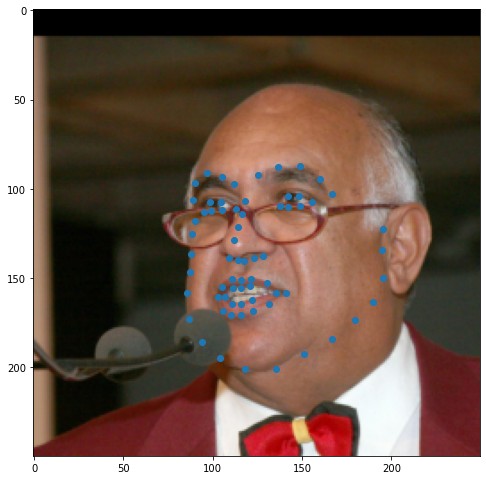

In [114]:
show_cropped_image_with_points_array(all_x, all_y, 420)

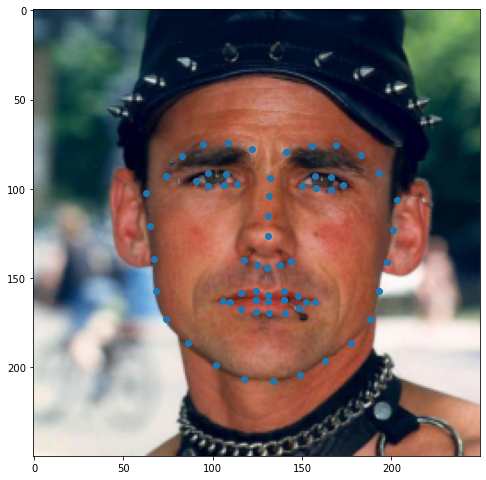

In [102]:
show_cropped_image_with_points(all_train_data[333])

In [9]:
def show_image_with_box_and_points(data_point):
    
    fig = plt.figure(figsize=(8, 10))
    
    ax = fig.subplots()

    ax.imshow(data_point['image'])
    box = data_point['box']
    rect = patches.Rectangle((box[1], box[0]), box[2], box[3], linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    keypoints = data_point['keypoints']
    ax.scatter(*zip(*(keypoints)))

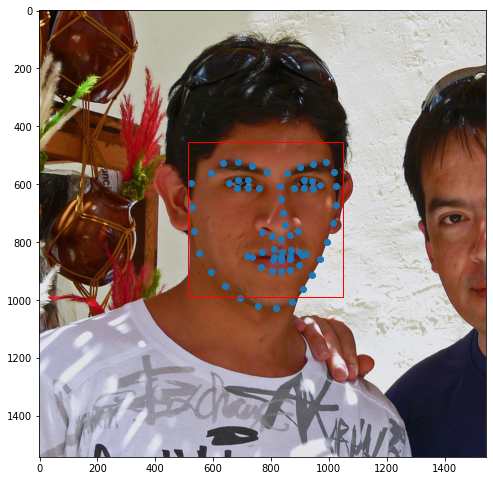

In [23]:
show_image_with_box_and_points(all_train_data[15])

### What's the farthest deviation from the center?

deviation defined as:

$$ \left\{ \left(\max_{keypoints}\frac{abs(midpoint_x - keypoint_x)}{width \; box /2} \right), \left(\max_{keypoints}\frac{abs(midpoint_y - keypoint_y)}{height \; box /2} \right)\right \}$$

Then, if we just expand the boxes by this value, it will encompass all of the keypoints. Then, we can throw awae the rest of the image.

In [ ]:
max_deviation(data):
    # get the max x deviation

In [46]:
all_train_data

[{'image': array([[[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],
  
         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],
  
         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],
  
         ...,
  
         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],
  
         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],
  
         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]]], dtype=uint8),
  'box': [78, 74, 138, 140],
  'keypoints': array([[ 55, 141],
         [ 59, 161],
        